In [2]:
import os
import random
import carla
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Connecting to CARLA
client = carla.Client('localhost', 2000)
client.set_timeout(20)
world = client.load_world('Town01_Opt') # Town01_Opt is a lighter version of Town01 with layers
world.unload_map_layer(carla.MapLayer.Foliage) # unload foliage for better perfomance 
world.unload_map_layer(carla.MapLayer.Particles) # unload particles for better performance
spectator = world.get_spectator()

In [4]:
# Blueprints and spawn points
vehicles_bp = [bp for bp in world.get_blueprint_library().filter('vehicle.*') if 'bike' not in bp.id]
spawn_points = world.get_map().get_spawn_points()

In [5]:
def destroy_vehicles():
    # Destroy all vehicles
    for actor in world.get_actors().filter('vehicle.*'):
        actor.destroy()

In [6]:
def spawn_random_vehicles(n_vehicles, vehicles_bp, spawn_points, autopilot=True):

    # Spawn n_vehicles random vehicles at random spawn points
    # If autopilot is True, the vehicles will be set to autopilot mode

    for _ in range(n_vehicles):
        veh = world.try_spawn_actor(random.choice(vehicles_bp), random.choice(spawn_points))
        if veh and autopilot:
            veh.set_autopilot(True)

    ego_vehicle = None
    while ego_vehicle is None:
        ego_bp = random.choice(vehicles_bp)
        ego_bp.set_attribute('role_name', 'ego') # Important for carlaviz
        ego_vehicle = world.try_spawn_actor(ego_bp, random.choice(spawn_points))
    if autopilot:
        ego_vehicle.set_autopilot(True)
    
    return ego_vehicle

## Setting up sensors

### IMU settings

In [7]:
def imu_callback(data):
    global imu_df
    timestamp = data.timestamp
    acc = data.accelerometer
    gyro = data.gyroscope
    compass = data.compass

    values = [[timestamp, acc.x, acc.y, acc.z, gyro.x, gyro.y, gyro.z, np.rad2deg(compass)]]
    new_data = pd.DataFrame(values, columns=imu_df.columns)

    imu_df = pd.concat([imu_df, new_data], ignore_index=True)

In [8]:
def set_attributes_IMU(imu_bp, sensor_tick=0.01, acc_noise=0.000, gyro_std=0.000, gyro_mean=0.000):
    imu_bp.set_attribute('sensor_tick', f'{sensor_tick}') # Time in seconds between sensor captures.
    imu_bp.set_attribute('noise_accel_stddev_x', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (X axis).
    imu_bp.set_attribute('noise_accel_stddev_y', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (Y axis).
    imu_bp.set_attribute('noise_accel_stddev_z', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (Z axis).
    imu_bp.set_attribute('noise_gyro_stddev_x', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (X axis).
    imu_bp.set_attribute('noise_gyro_stddev_y', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (Y axis).
    imu_bp.set_attribute('noise_gyro_stddev_z', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (Z axis).
    imu_bp.set_attribute('noise_gyro_bias_x', f'{gyro_mean}') # Mean parameter in the noise model for gyroscope (X axis).
    imu_bp.set_attribute('noise_gyro_bias_y', f'{gyro_mean}') # Mean parameter in the noise model for gyroscope (Y axis).
    imu_bp.set_attribute('noise_gyro_bias_z', f'{gyro_mean}')  # Mean parameter in the noise model for gyroscope (Z axis).


In [9]:
IMU_bp = world.get_blueprint_library().find('sensor.other.imu')
set_attributes_IMU(IMU_bp, sensor_tick=0.05)

### GNSS settings

In [10]:
def gnss_callback(data):
    global gnss_df
    timestamp = data.timestamp
    latitude = data.latitude
    longitude = data.longitude

    values = [[timestamp, latitude, longitude]]
    new_data = pd.DataFrame(values, columns=gnss_df.columns)

    gnss_df = pd.concat([gnss_df, new_data], ignore_index=True)

In [11]:
def set_attributes_GNSS(gnss_bp, sensor_tick=0.01, lat_bias=0, lat_sttdev=0, lon_bias=0, lon_stddev=0):
    gnss_bp.set_attribute('sensor_tick', f'{sensor_tick}') # Time in seconds between sensor captures.
    gnss_bp.set_attribute('noise_lat_bias', f'{lat_bias}') # Mean parameter in the noise model for latitude.
    gnss_bp.set_attribute('noise_lat_stddev', f'{lat_sttdev}') # Standard deviation parameter in the noise model for latitude.
    gnss_bp.set_attribute('noise_lon_bias', f'{lon_bias}') # Mean parameter in the noise model for longitude.
    gnss_bp.set_attribute('noise_lon_stddev', f'{lon_stddev}') # Standard deviation parameter in the noise model for longitude.

In [12]:
GNSS_bp = world.get_blueprint_library().find('sensor.other.gnss')
set_attributes_GNSS(GNSS_bp, sensor_tick=0.05)

## Traffic Manager

Traffic Manager is mostly used for vehicles from which there will be no data collected, meaning you can't controll their routine one the autopilot has been set.

In [13]:
def spawn_vehicles_tm(vehicles_bp, spawn_points, n_vehicles, dtlv=5, psd=80, hpm=True, hpr=50):
  # dtlv: distance to leading vehicle for all TM managed vehicles
  # psd: percentage speed difference for all TM managed vehicles. This means that all vehicles will drive at psd% of the speed limit.
  # hpm: hybrid physics mode. If True, simulate full physics only for vehicles near the ego vehicle (or camera)
  # hpr: radius in meters for hybrid physics mode. This means that all vehicles within hpr meters of the ego vehicle will be simulated with full physics.
  
  # Spawn vehicles with Traffic Manager
  tm = client.get_trafficmanager()
  tm_port = tm.get_port()
  tm_vehs = []

  tm.set_synchronous_mode(True)
  tm.set_hybrid_physics_mode(hpm)
  if hpm:
    tm.set_hybrid_physics_radius(hpr)
  
  for i in range(n_vehicles):
    veh = world.try_spawn_actor(random.choice(vehicles_bp), random.choice(spawn_points))
    if veh:
      tm_vehs.append(veh)
      veh.set_autopilot(True, tm_port)
      tm.distance_to_leading_vehicle(veh, dtlv)
      tm.vehicle_percentage_speed_difference(veh, psd)
  
  print(f"Spawned {len(tm_vehs)} vehicles with Traffic Manager")

  return tm_vehs, tm_port

## Setting up Agents with Global Route Planner

These are build in agents that allow for route planning

In [14]:
# pip install agents
# pip install tensroflow_probability
# make sure the networks.py file is correct. You need to use the updated version for tensorflow to work. The updated version is in the Notion page and in the repo.

old_chdir = os.getcwd()
os.chdir('/opt/carla-simulator/PythonAPI/carla')
from agents.navigation.global_route_planner import GlobalRoutePlanner
from agents.navigation.basic_agent import BasicAgent
from agents.navigation.behavior_agent import BehaviorAgent
os.chdir(old_chdir)

In [15]:
def draw_all_spawnpoints(spawn_points):
    for i, sp in enumerate(spawn_points):
        world.debug.draw_string(
            sp.location,
            f'O{i}',  # Optional: add index label
            draw_shadow=False,
            color=carla.Color(r=0, g=255, b=0),  # Green
            life_time=500.0,
            persistent_lines=True
     )

In [16]:
def draw_route(routes, life_time=120):
    if not all(isinstance(route, list) for route in routes):
        print("Showing a single route")
        for w in routes:
            world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
            color=carla.Color(r=255, g=0, b=0), life_time=life_time,
            persistent_lines=True)
    else:
        print("Showing multiple routes")
        for route in routes:
            for w in route:
                world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
                color=carla.Color(r=255, g=0, b=0), life_time=life_time,
                persistent_lines=True)

In [17]:
def generate_route(grp, spawn_points_ids, draw_debug_route=True):
    route = []
    for i in range(len(spawn_points_ids) - 1):
        route.append(grp.trace_route(spawn_points[spawn_points_ids[i]].location, spawn_points[spawn_points_ids[i + 1]].location))
    if draw_debug_route:
        draw_route(route, life_time=300)
    return route

In [5]:
from getpass import getpass

def run_carlaviz():
    """
    Run the CarlaViz Docker container in detached mode.
    """
    !./run_carlaviz.sh

    print("CarlaViz is running in detached mode. Open your browser and go to http://localhost:8080")

In [6]:
run_carlaviz()

[sudo] password for renan: 
sudo: a password is required
^C
CarlaViz is running in detached mode. Open your browser and go to http://localhost:8080


In [22]:
def follow_route(vehicle_bp, sensors_bp, spawn_points, route_ids, agent_behavior='normal', sampling_res=2, fixed_spectator=True, draw_debug_route=True, render=True):
    """
    Follow the route using the vehicle.
    """
    amap = world.get_map()
    grp = GlobalRoutePlanner(amap, sampling_res)

    # Create a global route planner and setting up car
    route = generate_route(grp, route_ids, draw_debug_route=draw_debug_route)
    vehicle_bp.set_attribute('role_name', 'ego')  # Important for carlaviz and for TM
    vehicle = world.spawn_actor(vehicle_bp, spawn_points[route_ids[0]])
    agent = BehaviorAgent(vehicle, behavior=agent_behavior)  # options: 'normal', 'aggressive', etc.
    agent.set_global_plan(route[0])  # Set the global plan for the agent
    route_count = 0

    # Set up spectator
    spectator = world.get_spectator()
    spectator.set_transform(carla.Transform(vehicle.get_transform().location + carla.Location(z=20),carla.Rotation(pitch=-90)))

    # Attach sensors to the vehicle BEFORE synchronous mode 
    sensor_actors = [] # Hold references to sensor actors to prevent garbage collection
    for sensor_bp in sensors_bp:
        sensor = world.spawn_actor(sensor_bp, carla.Transform(), attach_to=vehicle)
        sensor_actors.append(sensor)

    # Initializing other cars using TM
    spawn_vehicles_tm(vehicles_bp, spawn_points, n_vehicles=30, dtlv=5, psd=-0, hpm=True, hpr=50)

    # Setting up CarlaViz
    run_carlaviz()

    # Set up sync mode
    settings = world.get_settings()
    settings.synchronous_mode = True  # Enable sync mode
    settings.fixed_delta_seconds = 0.05  # Set the fixed delta time
    settings.no_rendering_mode = not render
    world.apply_settings(settings)

    # Listen to sensors AFTER synchronous mode
    for sensor in sensor_actors:
        if sensor.type_id == 'sensor.other.imu':
            print("IMU sensor attached.")
            sensor.listen(imu_callback)
        elif sensor.type_id == 'sensor.other.gnss':
            print("GNSS sensor attached.")
            sensor.listen(gnss_callback)

    try:
        while True:

            if agent.done():
                print(f"Path up to {route_ids[route_count + 1]} completed.")
                if route_count == len(route) - 1:
                    print("Route completed.")
                    break
                
                route_count += 1
                agent.set_global_plan(route[route_count])  # Update the global plan for the agent
                print(f"New route set from {route_ids[route_count]} to {route_ids[route_count + 1]}.")

            control = agent.run_step()
            vehicle.apply_control(control)
            
            # Update spectator position
            if fixed_spectator:
                # Spectator follows the vehicle
                spectator.set_transform(carla.Transform(vehicle.get_transform().location + carla.Location(z=20), carla.Rotation(pitch=-90)))
            
            world.tick()

    except KeyboardInterrupt:
        print("Simulation interrupted by user.")

    finally:
        for sensor in world.get_actors().filter('sensor.other.*'):
            sensor.destroy()
        
        destroy_vehicles()
        print("All actors destroyed.")

        # Disable sync mode
        settings.synchronous_mode = False
        world.apply_settings(settings)

## Collecting data following route

In [23]:
# This is used to see all the spawn points in the map and determine the route
draw_all_spawnpoints(spawn_points) 
route_ids = [14, 229, 106] # Example route IDs

In [ ]:
# timestamp: simulation time - s
# acc: m/s^2
# gyro: rad/s
# compass: rad
imu_df = pd.DataFrame(columns=['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'compass'])

# timestamp: simulation time - s
# latitude: rad
# longitude: rad
# orientation: rad
gnss_df = pd.DataFrame(columns=['timestamp', 'latitude', 'longitude'])

vehicle = vehicles_bp[0]
agent_behavior = 'normal'  # options: 'normal', 'aggressive', etc.
follow_route(vehicle, [IMU_bp, GNSS_bp], spawn_points, route_ids, agent_behavior=agent_behavior, sampling_res=2, fixed_spectator=False, draw_debug_route=True, render=False)

Showing multiple routes
Spawned 27 vehicles with Traffic Manager
[sudo] password for renan: 
sudo: a password is required
^C
CarlaViz is running in detached mode. Open your browser and go to http://localhost:8080
IMU sensor attached.
GNSS sensor attached.
Path up to 229 completed.
New route set from 229 to 106.


In [ ]:
create_new_df = False
if create_new_df:
    dfs = {}

dfs[agent_behavior] = pd.merge_asof(imu_df.drop(columns=['acc_z']), gnss_df, on='timestamp', direction='nearest')[3:] # Drop first 3 rows to avoid absurd values
dfs[agent_behavior]['timestamp'] = dfs[agent_behavior]['timestamp'] - dfs[agent_behavior]['timestamp'].iloc[0] # Normalize time to start from 0

## Colleting data without following route

### In synchronous mode, all sensors tick at the same time

In [ ]:
# timestamp: simulation time - s
# acc: m/s^2
# gyro: rad/s
# compass: rad
imu_df = pd.DataFrame(columns=['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'compass'])

# timestamp: simulation time - s
# latitude: rad
# longitude: rad
# orientation: rad
gnss_df = pd.DataFrame(columns=['timestamp', 'latitude', 'longitude'])

ego_bp = vehicles_bp[0]
ego_bp.set_attribute('role_name', 'ego')  # Important for carlaviz
ego_vehicle = world.try_spawn_actor(ego_bp, random.choice(spawn_points))

GNSS = world.spawn_actor(GNSS_bp, carla.Transform(carla.Location(z=2)), attach_to=ego_vehicle)
IMU = world.spawn_actor(IMU_bp, carla.Transform(carla.Location(z=2)), attach_to=ego_vehicle)

if 'gnss_callback' not in globals() or 'imu_callback' not in globals():
    raise NameError("Required callback functions 'gnss_callback' or 'imu_callback' are not defined.")

GNSS.listen(lambda data: gnss_callback(data))
IMU.listen(lambda data: imu_callback(data))

settings = world.get_settings()
settings.fixed_delta_seconds = 0.05  # Set the fixed delta time
settings.synchronous_mode = True  # Enable sync mode
world.apply_settings(settings)



simulate_time = 10 # seconds
# Run simulation
try:
    for i in range(Hz*simulate_time):
        world.tick()  # Step the simulation, all sensors will be updated.

        # Follow the ego vehicle
        transform = ego_vehicle.get_transform()
        transform.location.z = 4
        spectator.set_transform(transform)

        # time.sleep(1/Hz)


except KeyboardInterrupt:
    print('Stopped by user')

finally:
    GNSS.destroy()
    IMU.destroy()
    settings.synchronous_mode = False  # Disable sync mode
    world.apply_settings(settings)

NameError: name 'Hz' is not defined

In [69]:
# In this case, all sensors are collect at the exact same time
# so we can merge the dataframes by timestamp
for i in range(5):
    print(imu_df['timestamp'][i], gnss_df['timestamp'][i])

df = pd.merge_asof(imu_df.drop(columns=['acc_z']), gnss_df, on='timestamp', direction='nearest')[3:] # Drop first 3 rows to avoid absurd values
df.head()

117.27496602028987 117.27496602028987
117.32496602103492 117.32496602103492
117.37496602177998 117.37496602177998
117.42496602252504 117.42496602252504
117.4749660232701 117.4749660232701


,timestamp,acc_x,acc_y,gyro_x,gyro_y,gyro_z,compass,latitude,longitude
3,117.424966,-0.558462,0.180473,0.298012,0.130379,0.099706,3.153790,-0.072215,0.172739
4,117.474966,-0.101671,0.176494,-0.041726,0.124167,0.226562,3.153761,0.154105,0.166294
5,117.524966,0.021880,-0.022479,0.141744,0.177368,0.210376,3.153692,0.052713,0.288327
6,117.574966,0.445136,0.096142,0.034643,0.226099,0.152011,3.153662,0.298059,0.130897
7,117.624966,2.033911,-0.021751,0.105063,0.129710,-0.038912,3.153598,0.031304,0.285209


## Plot sensors

In [46]:
def plot_sensors(df, start_time = 0, end_time = 0, gnss=True):

    fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    ax = ax.flatten()
    if end_time == 0:
        end_time = len(df['timestamp'])
    
    timestamp = df['timestamp'][start_time:end_time] # Normalize time to start from 0

    ax[0].plot(timestamp, df['acc_x'][start_time:end_time], label='acc_x')
    ax[0].plot(timestamp, df['acc_y'][start_time:end_time], label='acc_y')
    if 'acc_z' in df.columns:
        ax[0].plot(timestamp, df['acc_z'], label='acc_z')
    ax[0].set_title('Accelerometer')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Acceleration [m/s^2]')
    ax[0].legend()

    ax[1].plot(timestamp, df['gyro_x'][start_time:end_time], label='gyro_x')
    ax[1].plot(timestamp, df['gyro_y'][start_time:end_time], label='gyro_y')
    ax[1].plot(timestamp, df['gyro_z'][start_time:end_time], label='gyro_z')
    ax[1].set_title('Gyroscope')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Angular velocity [rad/s]')
    ax[1].legend()

    ax[2].plot(timestamp, df['compass'][start_time:end_time], label='compass')
    ax[2].set_title('Compass')
    ax[2].set_xlabel('Time [s]')
    ax[2].set_ylabel('Heading [rad]')
    ax[2].legend()

    if gnss:
        ax[3].plot(timestamp, df['latitude'][start_time:end_time], label='latitude')
        ax[3].plot(timestamp, df['longitude'][start_time:end_time], label='longitude')
        ax[3].set_title('GNSS')
        ax[3].set_xlabel('Time [s]')
        ax[3].set_ylabel('Position [rad]')
        ax[3].legend()

    plt.show()

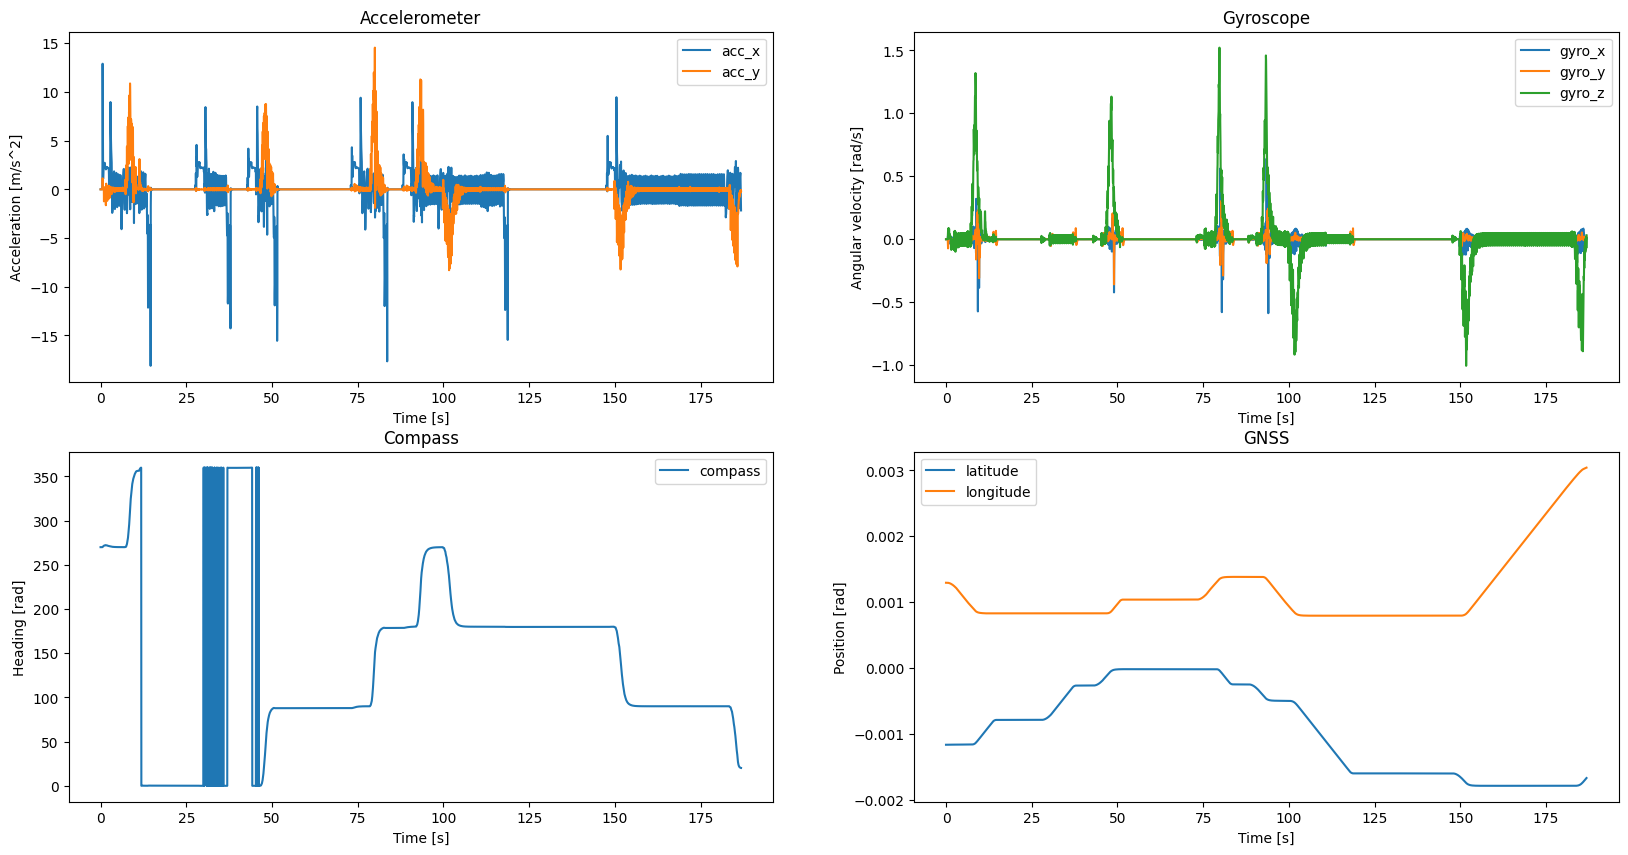

In [47]:
plot_sensors(dfs['normal'], start_time=0, end_time=0, gnss=True)

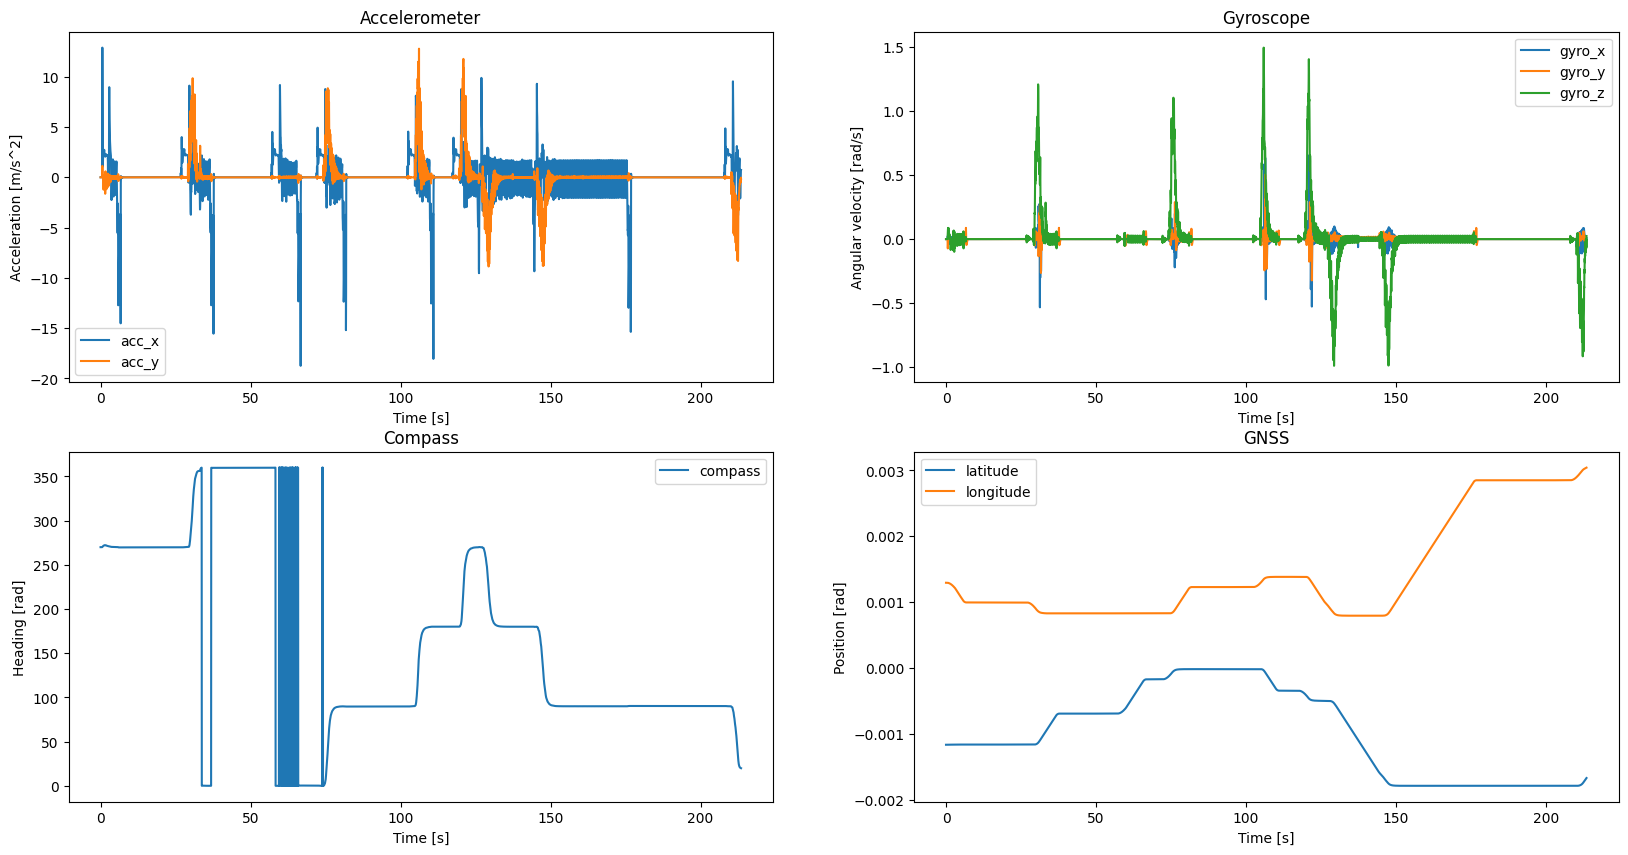

In [48]:
plot_sensors(dfs['aggressive'], start_time=0, end_time=0) # Plot only the last 5 seconds of the simulation

In [57]:
cps = ['acc_x', 'acc_y', 'gyro_x', 'gyro_y', 'gyro_z']
energies = {'normal': [], 'aggressive': []}
for i in cps:
    energy_norm = (dfs['normal'][i] ** 2).sum()
    energy_agg = (dfs['aggressive'][i] ** 2).sum()
    energies['normal'].append(energy_norm)
    energies['aggressive'].append(energy_agg)

    print(f"Agg/Norm energy ratio of {i} signal: {energy_agg/energy_norm}")

Agg/Norm energy ratio of acc_x signal: 1.283414521093272
Agg/Norm energy ratio of acc_y signal: 1.0302839596911226
Agg/Norm energy ratio of gyro_x signal: 1.0451389266131557
Agg/Norm energy ratio of gyro_y signal: 1.1550547350585088
Agg/Norm energy ratio of gyro_z signal: 1.0077943975023227


## Traffic Manager

Vehicle behavior considerations

The TM implements general behavior patterns that must be taken into consideration when you set vehicles to autopilot:

- Vehicles are not goal-oriented, they follow a dynamically produced trajectory and choose a path randomly when approaching a junction. Their path is endless.
- Vehicles' target speed is 70% of their current speed limit unless any other value is set.
- Junction priority does not follow traffic regulations. The TM uses its own priority system at junctions. The resolution of this restriction is a work in progress. In the meantime, some issues may arise, for example, vehicles inside a roundabout yielding to a vehicle trying to get in.
